In [1]:
from abc import ABC, abstractmethod
import math
import numpy as np
import torch
from torch import utils
from torch import nn
from torch import distributions
from torch import optim
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToPILImage
from IPython.display import Image

In [2]:
data_dir = '/Users/armandli/data/'

In [3]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [4]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
score_args = {'batch_size' : default_batch_size, 'shuffle' : False}
if use_cuda:
    loader_args.update({'pin_memory' : True})
    score_args.update({'pin_memory' : True})

In [5]:
class Reporter(ABC):
    @abstractmethod
    def report(self, typ, **metric):
        pass
    @abstractmethod
    def reset(self):
        pass

In [6]:
class SReporter(Reporter):
    def __init__(self):
        self.log = []
    def report(self, typ, **data):
        self.log.append((typ, data))
    def reset(self):
        self.log.clear()
    def loss(self, t):
        losses = []
        for (typ, data) in self.log:
            if typ == t:
                losses.append(data['loss'])
        return losses
    def loss(self, t, idx):
        if idx >= 0:
            count = 0
            for (typ, data) in self.log:
                if typ == t:
                    if count == idx:
                        return data['loss']
                    count += 1
        else:
            count = -1
            for (typ, data) in reversed(self.log):
                if typ == t:
                    if count == idx:
                        return data['loss']
                    count -= 1
        return float("inf")
    def eval_loss(self):
        return self.loss('eval')
    def train_loss(self):
        return self.loss('train')
    def eval_loss(self, idx):
        return self.loss('eval', idx)
    def train_loss(self, idx):
        return self.loss('train', idx)
    def get_record(self, t, idx):
        if idx >= 0:
            count = 0
            for (typ, data) in self.log:
                if typ == t:
                    if count == idx:
                        return data
                    count += 1
        else:
            count = -1
            for (typ, data) in reversed(self.log):
                if typ == t:
                    if count == idx:
                        return data
                    count -= 1
        return dict()
    def eval_record(self, idx):
        return self.get_record('eval', idx)
    def train_record(self, idx):
        return self.get_record('train', idx)

In [7]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
    
    def forward(self, pred, target, mu, sig):
        recon_loss = ((target - pred)**2.).sum()
        dkl_loss = (sig**2. + mu**2. - torch.log(sig) - 0.5).sum()
        return recon_loss + dkl_loss

In [8]:
class Exp(nn.Module):
    def __init__(self):
        super(Exp, self).__init__()
    
    def forward(self, input):
        return torch.exp(input)

In [9]:
class VariationalEncoderV1(nn.Module):
    def __init__(self, idim, hdim, zdim):
        super(VariationalEncoderV1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(idim, hdim),
            nn.ReLU(inplace=True),
        )
        self.mu_layer = nn.Linear(hdim, zdim)
        self.sig_layer = nn.Sequential(
            nn.Linear(hdim, zdim),
            Exp(), #NOTE: this could explode, need to regularize it
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.layer1(x)
        mu = self.mu_layer(x)
        sig = self.sig_layer(x)
        if torch.isnan(sig).sum() > 0:
            print(f"NaN in sig")
        return (mu, sig)

In [10]:
class VariationalEncoderV2(nn.Module):
    def __init__(self, idim, hdim, zdim):
        super(VariationalEncoderV2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(idim, hdim),
            nn.ReLU(inplace=True),
        )
        self.mu_layer = nn.Linear(hdim, zdim)
        self.sig_layer = nn.Sequential(
            nn.Linear(hdim, zdim),
            nn.Softplus(threshold=6),
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.layer1(x)
        mu = self.mu_layer(x)
        sig = self.sig_layer(x)
        if torch.isnan(sig).sum() > 0:
            print(f"NaN in sig!")
        return (mu, sig)

In [11]:
class DecoderV1(nn.Module):
    def __init__(self, idim, hdim, zdim):
        super(DecoderV1, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(zdim, hdim),
            nn.ReLU(inplace=True),
            nn.Linear(hdim, idim),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.layer(x)
        return x

In [12]:
class VariationalAutoEncoderV1(nn.Module):
    def __init__(self, idim, hdim, zdim, dist):
        super(VariationalAutoEncoderV1, self).__init__()
        self.encoder = VariationalEncoderV2(idim, hdim, zdim)
        self.decoder = DecoderV1(idim, hdim, zdim)
        self.dist = dist
    
    def forward(self, x, device):
        mu, sig = self.encoder(x)
        s = self.dist.sample(mu.shape).to(device)
        z = mu + sig * s
        x_h = self.decoder(z)
        return (x_h, mu, sig)

    def encode(self, x):
        mu, sig = self.encoder(x)
        return (mu, sig)

    def decode(self, mu, sig, device):
        s = self.dist.sample(mu.shape).to(device)
        z = mu + sig * s
        x_h = self.decoder(z)
        return x_h

In [13]:
def vae_image_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    total_loss = 0.
    for x, _ in loader:
        optimizer.zero_grad()
        x = x.to(device)
        x_h, mu, sig = model(x, device)
        x_h = x_h.reshape(x.shape)
        l = loss(x_h, x, mu, sig)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    total_loss /= float(len(loader.dataset))
    reporter.report(typ='train', loss=total_loss)
    print(f"Train Loss: {total_loss}")

In [14]:
def vae_image_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            x_h, mu, sig = model(x, device)
            x_h = x_h.reshape(x.shape)
            total_loss += loss(x_h, x, mu, sig)
    total_loss /= float(len(loader.dataset))
    reporter.report(typ='eval', loss=total_loss)

In [15]:
def vae_image_train_validate(
        model,
        device,
        train_loader,
        eval_loader,
        optimizer,
        scheduler,
        loss,
        total_epoch,
        patience,
        patience_decay,
        reporter,
):
    validation_loss = float("inf")
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        vae_image_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        vae_image_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_loss(-1)
        print(f"Epoch {epoch} Validation Loss: {new_validation_loss}")
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = False
        else:
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print(f"Improvement stopped. Validation Loss: {validation_loss}")
                break

In [16]:
# training

In [17]:
# selection of datasets

In [18]:
trainset = datasets.MNIST(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
evalset  = datasets.MNIST(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)

In [18]:
trainset = datasets.CIFAR10(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
evalset = datasets.CIFAR10(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
trainset = datasets.CIFAR100(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
evalset = datasets.CIFAR100(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
len(trainset), len(evalset)

(50000, 50000)

In [20]:
input_dim = torch.flatten(trainset[0][0]).shape[0]
input_dim

3072

In [21]:
train_loader = utils.data.DataLoader(dataset=trainset, **loader_args)
eval_loader = utils.data.DataLoader(dataset=evalset, **score_args)

In [22]:
norm_dist = distributions.Normal(0, 1)
model = VariationalAutoEncoderV1(input_dim, 1024, 512, norm_dist)
model = model.to(device)

In [23]:
learning_rate = 0.0001
total_epochs  = 60
patience      = 8
patience_decay= 0.9
optimizer     = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
scheduler     = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience/4, threshold=0.01)
loss          = VAELoss()
reporter      = SReporter()

In [24]:
vae_image_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Train Loss: 361.0521227734375
Epoch 0 Validation Loss: 331.14117431640625
Train Loss: 322.92201140625
Epoch 1 Validation Loss: 319.2463073730469
Train Loss: 314.0591126953125
Epoch 2 Validation Loss: 309.1727294921875
Train Loss: 307.99328328125
Epoch 3 Validation Loss: 306.78900146484375
Train Loss: 303.355739765625
Epoch 4 Validation Loss: 299.70318603515625
Train Loss: 297.8630059375
Epoch 5 Validation Loss: 296.04901123046875
Train Loss: 294.92276875
Epoch 6 Validation Loss: 292.6917724609375
Train Loss: 291.7872937109375
Epoch 7 Validation Loss: 290.6287536621094
Train Loss: 290.114244765625
Epoch 8 Validation Loss: 289.5167236328125
Train Loss: 289.2089483984375
Epoch 9 Validation Loss: 288.3432312011719
Train Loss: 288.2650948046875
Epoch 10 Validation Loss: 287.5272216796875
Train Loss: 287.03495046875
Epoch 11 Validation Loss: 288.11639404296875
Train Loss: 285.741744765625
Epoch 12 Validation Loss: 285.5701599121094
Train Loss: 285.5082698828125
Epoch 13 Validation Loss: 285.

In [24]:
# validation

In [25]:
to_img = ToPILImage()

In [26]:
x = evalset[64][0]
x.shape

torch.Size([3, 32, 32])

In [32]:
x = evalset[64][0]
x = x.reshape(1, 3, 32, 32)
x_h, _, _ = model(x.to(device), device)
x_h = x_h.to(device)
x_h = x_h.reshape(x.shape)

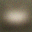

In [33]:

to_img(x_h[0])

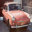

In [34]:
to_img(x.reshape(3, 32, 32))

In [ ]:
# generate image using mu and sig